In [25]:
import sys; sys.path.insert(0, '..')
from database.dataset import *

from feature_extraction.feature_extraction import CandidatesFeatureExtraction
from mc_candidate_proposal.hough_mc import HoughCalcificationDetection
from general_utils.plots import plot_blobs, plot_blobs_2_sets
from metrics.metrics import quick_circle_comparison, circle_comparison
from general_utils.utils import min_max_norm, patch_coordinates_from_center, get_an_example_array
import matplotlib.pyplot as plt
from general_utils.plots import plot_gabor_filters
import pickle
from metrics.metrics_utils import get_tp_fp_fn_center_patch_criteria
from mc_candidate_proposal.morphology_mc import MorphologyCalcificationDetection
from general_utils.plots import draw_our_haar_like_features
from skimage.feature import draw_haar_like_feature
import feature_extraction.haar_features.haar_modules as hm

In [10]:
db = INBreast_Dataset(
    return_lesions_mask=True,
    level='image',
    max_lesion_diam_mm=None,
    extract_patches=False,
    partitions = ['train', 'validation'],
    lesion_types = ['calcification', 'cluster'],
    cropped_imgs = True,
    keep_just_images_of_lesion_type = False,
    use_muscle_mask=True,
    ignore_diameter_px = 15
)

### GABOR

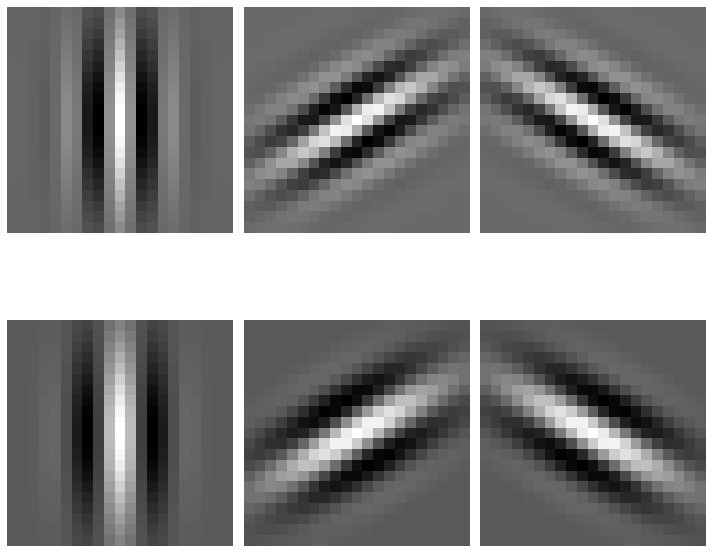

In [8]:
# FE class initialization
gabor_params = {'scale':2, 'orientation':3, 'max_freq':0.2, 'ksize':(20, 20), 'sigma':3}

cfe  = CandidatesFeatureExtraction(patch_size=14, gabor_params=gabor_params)
gabor_fb = cfe.gabor_feature_bank(**gabor_params)
plot_gabor_filters(gabor_fb)


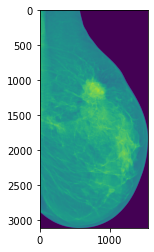

In [54]:
plt.imshow(db[34]['img'])

In [55]:
import pywt
def get_wavelet_decomp(patch: np.ndarray, wavelet_type = 'haar'):
    """ Gets wavelet decomposition of two levels with approximation and detail coefficients.
    Uses decimated 2D forward Discrete Wavelet Transform

    Args:
        patch (np.ndarray): image patch (normalized)
        wavelet_type (str, optional): type of wavelet for decomposition. Defaults to 'haar'.

    Returns:
        decompositions (list[np.ndarray]): list of decompositions [LL1,LH1,HL1,HH1,LL2,LH2,HL2,HH2]
    """
    LL1,(LH1,HL1,HH1) = pywt.dwt2(patch,wavelet_type) 
    LL2,(LH2,HL2,HH2) = pywt.dwt2(LL1,wavelet_type)
    return [LL1,LH1,HL1,HH1,LL2,LH2,HL2,HH2]

from mc_candidate_proposal.morphology_mc import MorphologyCalcificationDetection

threshold = 0.95
min_distance = 6
area = 14
filter_muscle=False

idx = 34
case = db[idx]
image = case['img']
image_id = case['img_id']
lesion_mask = case['lesion_mask']
processed_imgs_path = '/home/acortinau/projects/calc-det/data/gsm_imgs'

md = MorphologyCalcificationDetection(
    processed_imgs_path, threshold=threshold, min_distance=min_distance,
    area=area*area, store_intermediate=False, filter_muscle_region=filter_muscle)

candidate_blobs = md.detect(image, image_id)


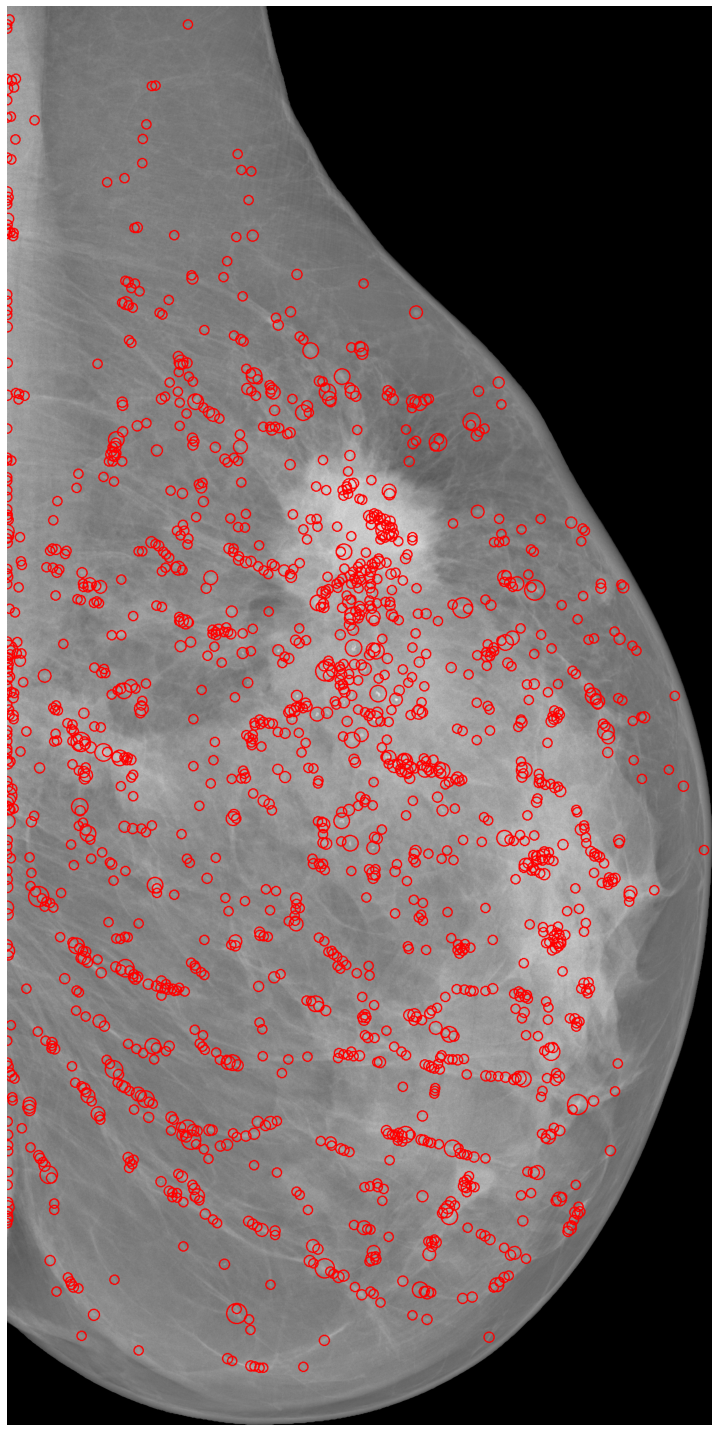

In [66]:
plot_blobs(min_max_norm(image,255),candidate_blobs)

In [68]:
candidate_blobs[10,0:2],image.shape

(array([ 163, 2915]), (3111, 1545))

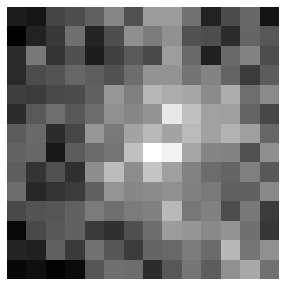

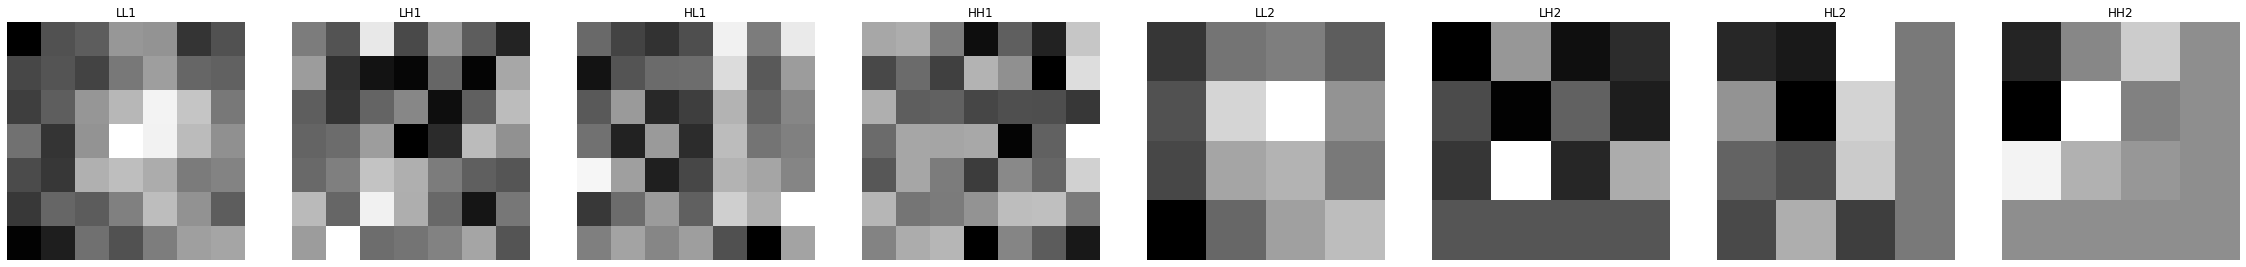

In [73]:
image = min_max_norm(image,1)
patch_size = 14
patch_x1, patch_x2, patch_y1, patch_y2 = patch_coordinates_from_center(candidate_blobs[100,0:2], image.shape, patch_size) #10
image_patch = image[patch_y1:patch_y2, patch_x1:patch_x2]
decomp = get_wavelet_decomp(image_patch)
plt.figure(figsize=(5,5))
plt.imshow(image_patch,cmap='gray')
plt.axis('off')
plt.show()
f,ax = plt.subplots(1,8,figsize=(40,5))
wavelet_decomp_names = ['LL1', 'LH1', 'HL1', 'HH1', 'LL2', 'LH2', 'HL2', 'HH2']
for idx,dec in enumerate(decomp):
    ax[idx].imshow(dec,cmap='gray')
    ax[idx].axis('off')
    ax[idx].set_title(wavelet_decomp_names[idx])

In [3]:
with open('../images/wavelet_glcm_alltrain_allcand_newf_p14', 'rb') as f:
    x = pickle.load(f)

In [4]:
data = pd.concat(x).sample(frac=1) # merge and shuffle
data

,patch_mean_LL1,patch_skew_LL1,patch_std_LL1,patch_kur_LL1,patch_entropy_LL1,patch_uniformity_LL1,patch_relsmooth_LL1,patch_mean_LH1,patch_skew_LH1,patch_std_LH1,...,pi_o2_img_mean,pi_o2_img_range,pi_o2_img_mean_abs_deviation,pi_o2_img_rms,pi_o2_img_std,pi_o2_img_skew,pi_o2_img_kurt,coordinates,patch_mask_intersection,img_id
927,1.091259,0.031072,0.043369,-0.842359,5.614710,0.020408,0.041566,0.002012,0.061770,0.012340,...,0.000015,0.005952,0.00003,0.000301,0.000301,19.674801,385.097808,"((2381, 2395), (989, 1003))",0,22679008
101,1.587455,-0.201246,0.031503,0.764451,5.614710,0.020408,0.030541,0.002650,0.059972,0.015628,...,0.000015,0.005952,0.00003,0.000301,0.000301,19.674801,385.097808,"((743, 757), (462, 476))",0,20588536
401,1.576413,0.018606,0.030241,-0.771802,5.573894,0.021241,0.029354,0.000768,-0.071535,0.013311,...,0.000015,0.005952,0.00003,0.000301,0.000301,19.674801,385.097808,"((1551, 1565), (1011, 1025))",0,20587784
318,0.923794,-0.312730,0.035811,-1.085544,5.614710,0.020408,0.034573,0.001504,0.056072,0.009273,...,0.000015,0.005952,0.00003,0.000301,0.000301,19.674801,385.097808,"((2315, 2329), (1507, 1521))",0,20586986
252,1.278184,0.100023,0.036819,-0.822225,5.614710,0.020408,0.035511,0.000757,-0.236525,0.011162,...,0.000015,0.005952,0.00003,0.000301,0.000301,19.674801,385.097808,"((1728, 1742), (517, 531))",0,24055149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1631,1.451565,0.367519,0.031246,0.198420,5.573894,0.021241,0.030299,0.001444,0.073415,0.013951,...,0.000015,0.011905,0.00003,0.000303,0.000303,20.021579,407.765856,"((2522, 2536), (238, 252))",0,24055931
367,1.455565,-0.304661,0.042372,-0.681457,5.614710,0.020408,0.040650,-0.001381,0.019157,0.014687,...,0.000015,0.011905,0.00003,0.000303,0.000303,20.021579,407.765856,"((1747, 1761), (551, 565))",0,24065461
447,1.250427,-0.027964,0.048056,-0.960899,5.614710,0.020408,0.045852,0.002091,-0.454280,0.009950,...,0.000015,0.005952,0.00003,0.000301,0.000301,19.674801,385.097808,"((1340, 1354), (1024, 1038))",0,22614379
856,1.460342,0.626287,0.036299,-0.291774,5.573894,0.021241,0.035028,0.001693,-0.311696,0.012349,...,0.000015,0.005952,0.00003,0.000301,0.000301,19.674801,385.097808,"((2495, 2509), (338, 352))",0,22670832


In [6]:
list(data.columns)

['patch_mean_LL1',
 'patch_skew_LL1',
 'patch_std_LL1',
 'patch_kur_LL1',
 'patch_entropy_LL1',
 'patch_uniformity_LL1',
 'patch_relsmooth_LL1',
 'patch_mean_LH1',
 'patch_skew_LH1',
 'patch_std_LH1',
 'patch_kur_LH1',
 'patch_entropy_LH1',
 'patch_uniformity_LH1',
 'patch_relsmooth_LH1',
 'patch_mean_HL1',
 'patch_skew_HL1',
 'patch_std_HL1',
 'patch_kur_HL1',
 'patch_entropy_HL1',
 'patch_uniformity_HL1',
 'patch_relsmooth_HL1',
 'patch_mean_HH1',
 'patch_skew_HH1',
 'patch_std_HH1',
 'patch_kur_HH1',
 'patch_entropy_HH1',
 'patch_uniformity_HH1',
 'patch_relsmooth_HH1',
 'patch_mean_LL2',
 'patch_skew_LL2',
 'patch_std_LL2',
 'patch_kur_LL2',
 'patch_entropy_LL2',
 'patch_uniformity_LL2',
 'patch_relsmooth_LL2',
 'patch_mean_LH2',
 'patch_skew_LH2',
 'patch_std_LH2',
 'patch_kur_LH2',
 'patch_entropy_LH2',
 'patch_uniformity_LH2',
 'patch_relsmooth_LH2',
 'patch_mean_HL2',
 'patch_skew_HL2',
 'patch_std_HL2',
 'patch_kur_HL2',
 'patch_entropy_HL2',
 'patch_uniformity_HL2',
 'patch_r

In [7]:
len(data.img_id.unique())

154

### HAAR

In [5]:
# Feature extractor
haar_params = {
    'skimage': {
        'feature_type': None, 'feature_coord': None
    },
    'ours': {
        'horizontal_feature_types': [(hm.Feature4h, 1, 4), (hm.Feature4v, 4, 1), (hm.Feature3h3v, 3, 3)],
        'rotated_feature_types': None,
        'horizontal_feature_selection': None,
        'rotated_feature_selection': None,
    },
    'patch_size': 14
}
cfe  = CandidatesFeatureExtraction(patch_size=14, fos=False, haar_params=haar_params)

In [12]:
threshold = 0.95
min_distance = 6
area = 14
filter_muscle=False

idx = 0
# Get image to process
db_sample = db[idx]
image = db_sample['img']
image_id = db.df.iloc[idx].img_id
muscle_mask = db_sample['muscle_mask']
image_mask = db_sample['lesion_mask']
processed_imgs_path = '/home/acortinau/projects/calc-det/data/gsm_imgs'
# candidate detection

md = MorphologyCalcificationDetection(
    processed_imgs_path, threshold=threshold, min_distance=min_distance,
    area=area*area, store_intermediate=False, filter_muscle_region=filter_muscle)

candidate_blobs = md.detect(image, image_id)
tp, fp, fn, ignored_candidates = get_tp_fp_fn_center_patch_criteria(candidate_blobs, image_mask, None, 14)
candidates = pd.concat([tp, fp], axis=0, ignore_index=True)
X = cfe.extract_features(candidates.loc[:,['x','y','radius']].values.astype(int), image)
del X, tp, fp, fn, muscle_mask, image_id

In [13]:
skimage_types = cfe.skimage_haar_feature_types
h_types = np.asarray(cfe.our_haar_feature_types_h)
r_types = np.asarray(cfe.our_haar_feature_types_r)

In [39]:
len(skimage_types),len(h_types),len(r_types),(len(skimage_types)+len(h_types)+ len(r_types))

(18991, 5310, 4342, 28643)

#### HAAR GSM

In [17]:
with open('/home/acortinau/projects/calc-det/data/final_haar_500_feat_selection_gsm.p', 'rb') as f:
    selection = pickle.load(f)

In [18]:
len(selection['skimage_haar_feature_types_sel']) + len(selection['hor_feats_selection']) + len(selection['rot_feats_selection'])

500

In [28]:
# ISTANTIATE the candidate Feature Extractor with the selected features.
haar_params = {
    'skimage': {
        'feature_type': selection['skimage_haar_feature_types_sel'],
        'feature_coord': selection['skimage_haar_feature_coords_sel']
    },
    'ours': {
        'horizontal_feature_selection': selection['hor_feats_selection'].tolist(),
        'rotated_feature_selection': selection['rot_feats_selection'].tolist(),
        'rotated_feature_types': None,
        'horizontal_feature_types': None
    },
    'patch_size': 14
}
cfe_sel  = CandidatesFeatureExtraction(patch_size=14, fos=False, haar_params=haar_params)
X = cfe_sel.extract_features(candidate_blobs, image)
del X

images = get_an_example_array(image, 14, candidate_blobs.astype(int))


In [30]:
images.shape

(1111, 14, 14)

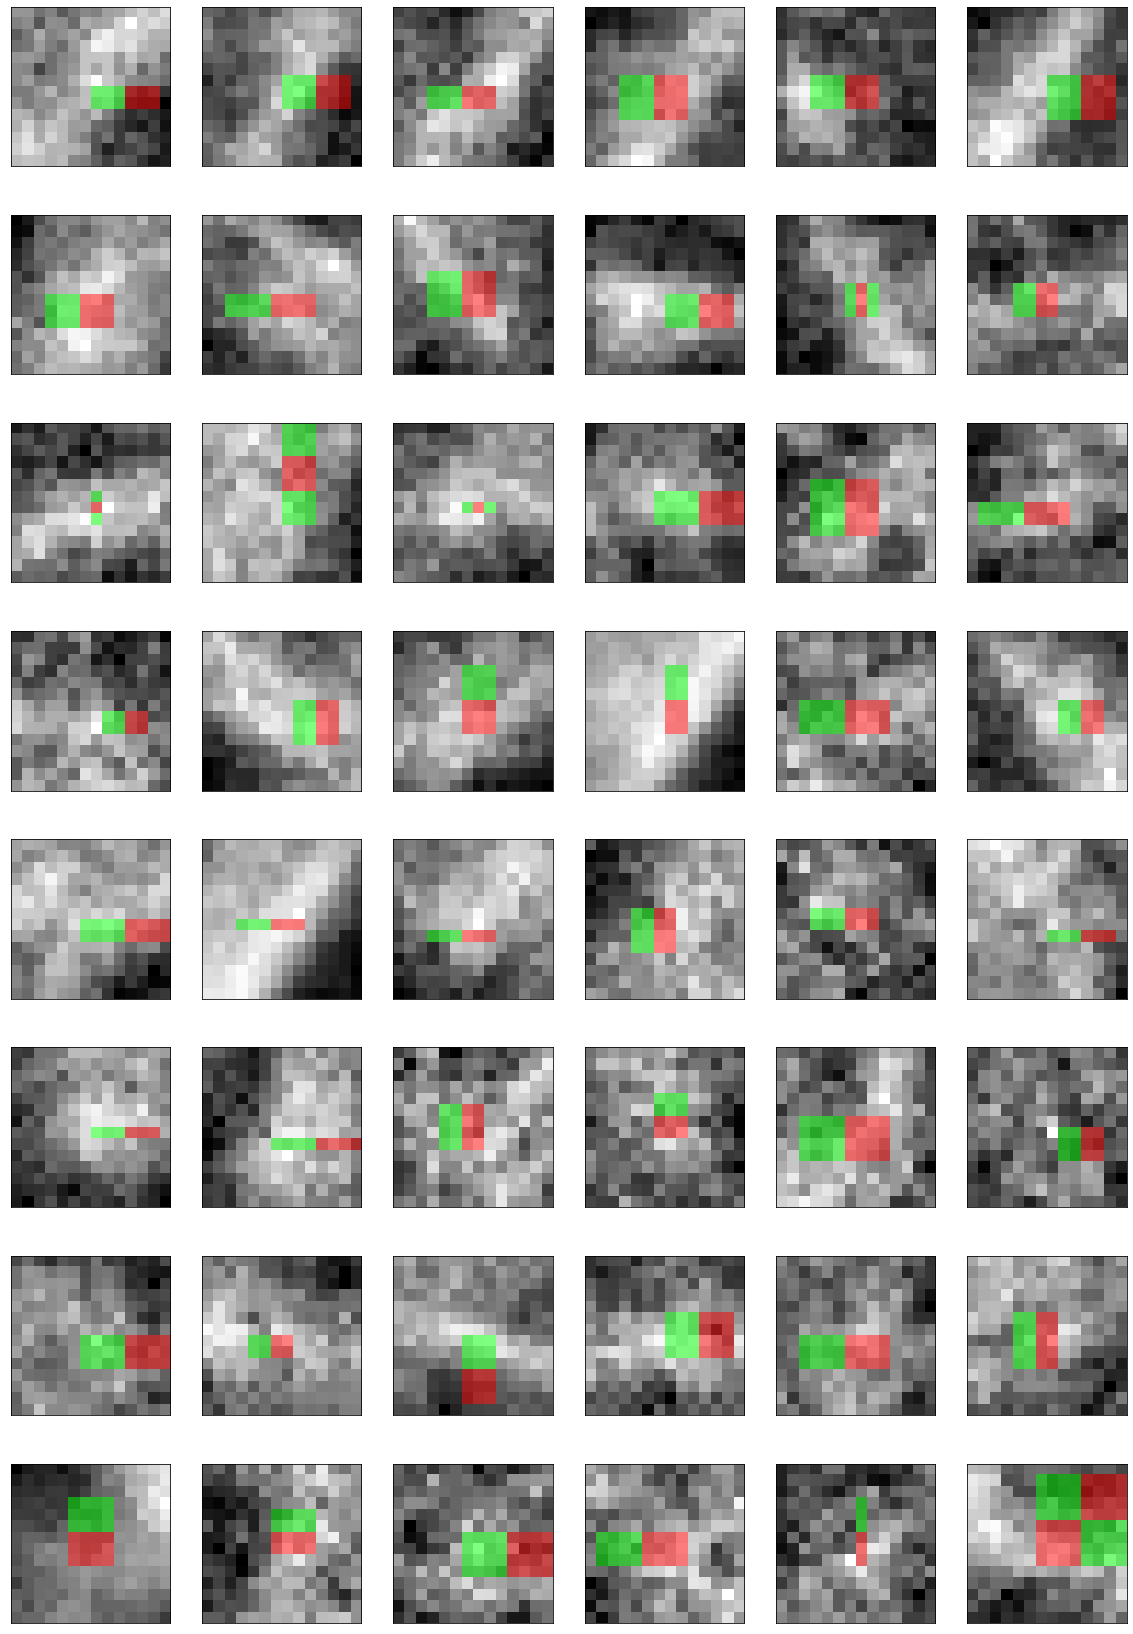

In [34]:
fig, axs = plt.subplots(8, 6, figsize=(20,30))
for idx, ax in enumerate(axs.ravel()):
    img = utils.min_max_norm(images[100+idx], 1.).astype('float')
    img = draw_haar_like_feature(
        img, 0, 0, images.shape[2], images.shape[1], [cfe_sel.skimage_haar_feature_coords[idx]])
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

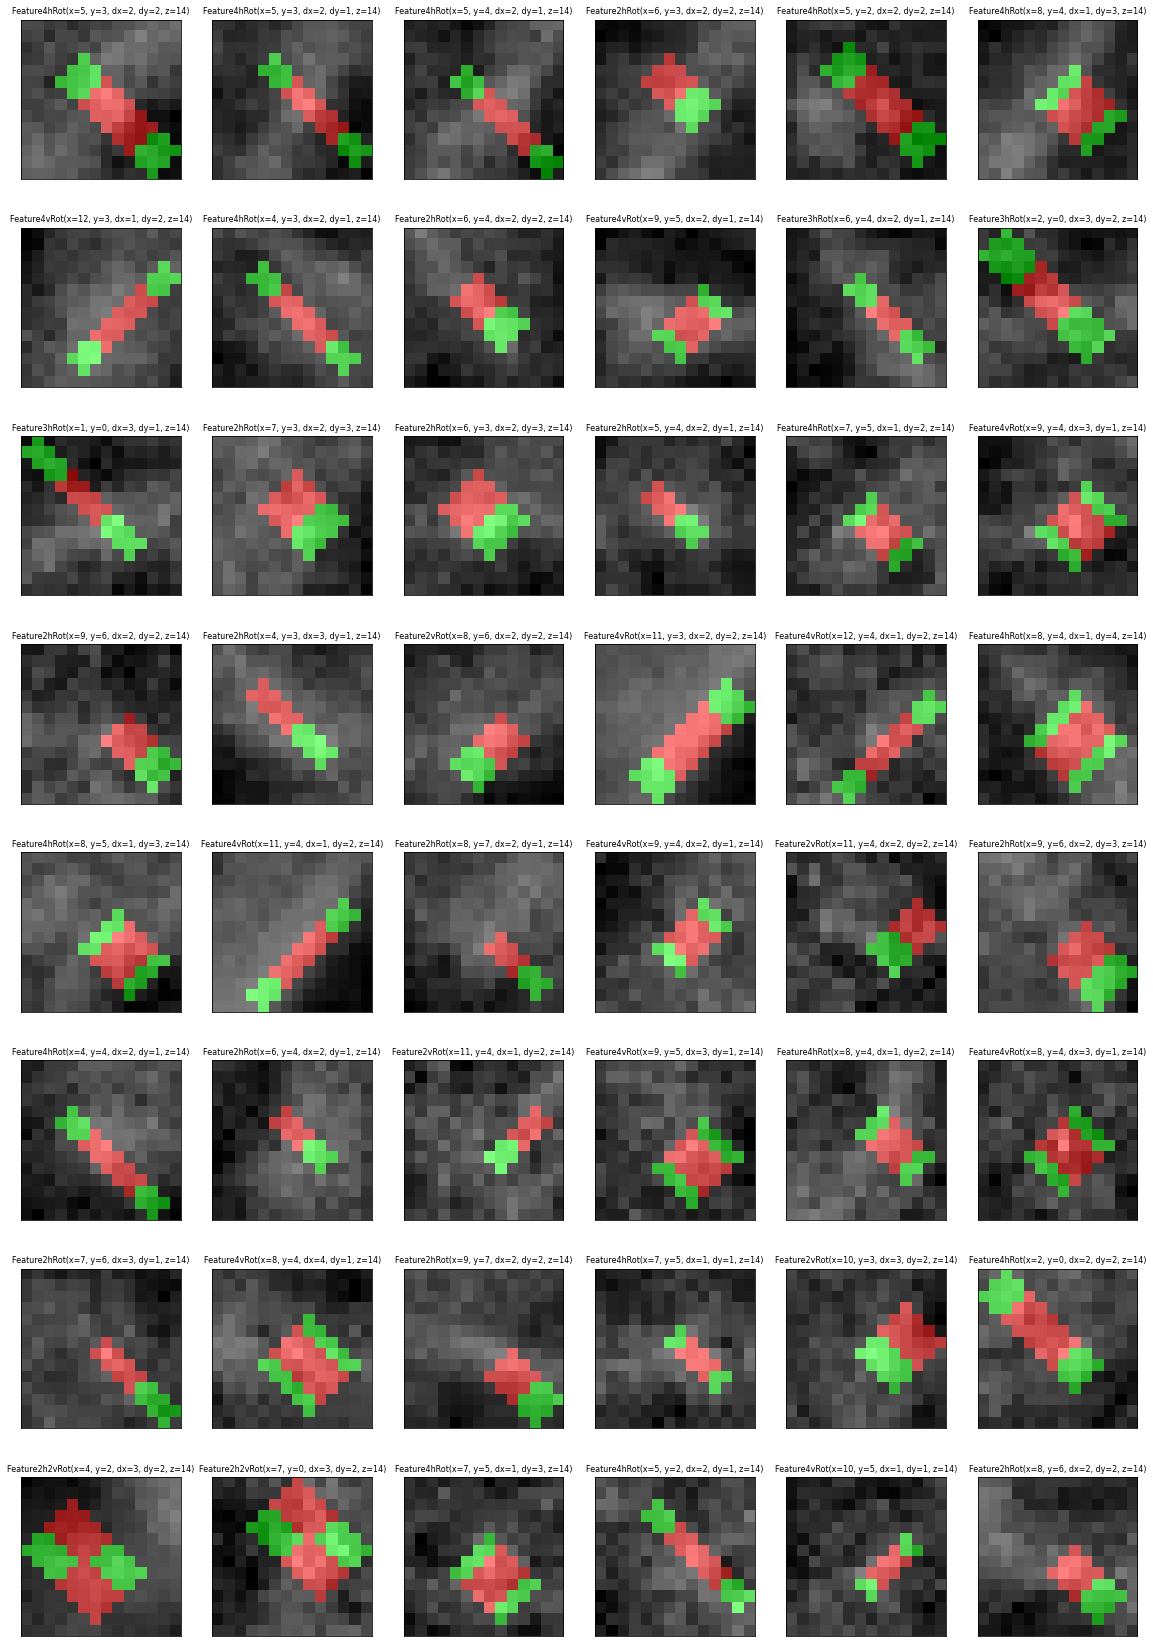

In [33]:
bfig, axs = plt.subplots(8, 6, figsize=(20,30))
for ax, img, feat in zip(np.ravel(axs), images[100:,:,:], cfe_sel.our_haar_feature_types_h[:48]):
    image = draw_our_haar_like_features(img, feat, rot=False)
    ax.imshow(image)
    ax.set_title(feat,fontsize=8)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [36]:
params = cfe_sel.haar_params['ours']['horizontal_feature_types']
params

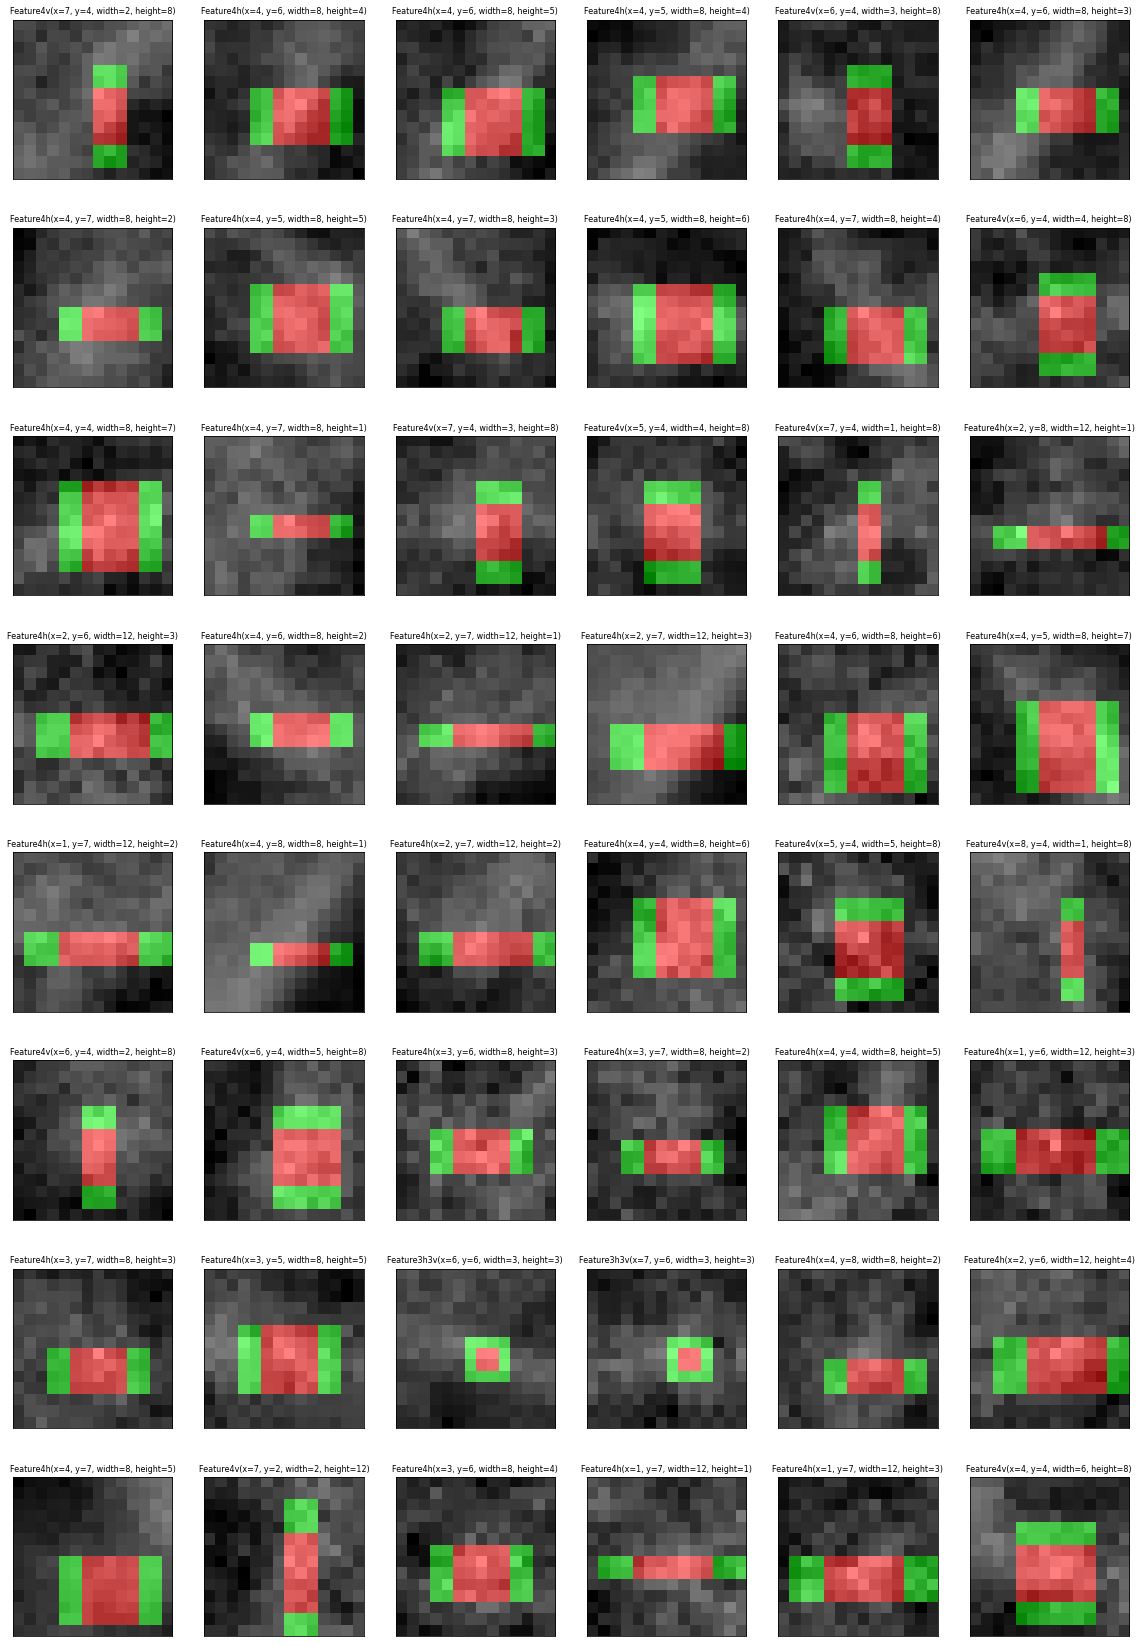

In [42]:
fig, axs = plt.subplots(8, 6, figsize=(20,30))
for ax, img, feat in zip(np.ravel(axs), images[100:,:,:], cfe_sel.our_haar_feature_types_r[:48]):
    image = draw_our_haar_like_features(img, feat, rot=False)
    ax.imshow(image)
    ax.set_title(feat,fontsize=8)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [44]:
detector = 'gsm'
path = (Path.cwd().parent.parent / f'data/haar_models_{detector}/')

aupr_test = pd.read_csv(path/'aupr_test_all_sorted.csv', index_col=0)
cols = aupr_test.columns
aupr_test.reset_index(drop=False, inplace=True)
aupr_test = pd.melt(aupr_test, id_vars=['index'], value_vars=cols)

aucs_test = pd.read_csv(path/'aucs_test_all_sorted.csv', index_col=0)
cols = aucs_test.columns
aucs_test.reset_index(drop=False, inplace=True)
aucs_test =pd.melt(aucs_test, id_vars=['index'], value_vars=cols)

aupr_train = pd.read_csv(path/'aupr_train_all_sorted.csv', index_col=0)
cols = aupr_train.columns
aupr_train.reset_index(drop=False, inplace=True)
aupr_train = pd.melt(aupr_train, id_vars=['index'], value_vars=cols)

aucs_train = pd.read_csv(path/'auc_train_all_sorted.csv', index_col=0)
cols = aucs_train.columns
aucs_train.reset_index(drop=False, inplace=True)
aucs_train =pd.melt(aucs_train, id_vars=['index'], value_vars=cols)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

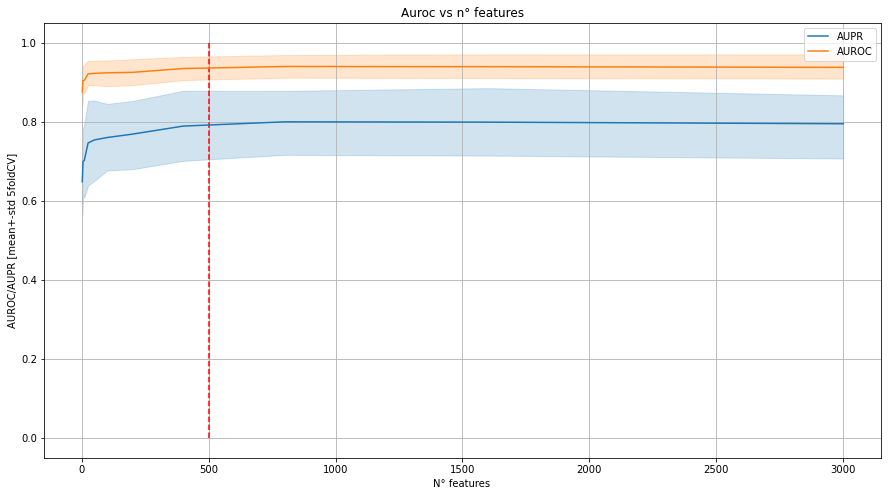

In [45]:
cmap = plt.get_cmap("tab10")
fig, ax = plt.subplots(1,1, figsize=(15,8))
ax.set_title('Auroc vs n° features')
sns.lineplot(x = aupr_test.variable.values.astype(int), y = aupr_test.value, ax=ax, color=cmap(0), label='AUPR')
sns.lineplot(x = aucs_test.variable.values.astype(int), y = aucs_test.value, ax=ax, color=cmap(1), label='AUROC')
ax.set_xlabel('N° features ')
ax.set_ylabel('AUROC/AUPR [mean+-std 5foldCV]')
plt.vlines(x=500, ymin=0, ymax=1, ls='--', color='r')
plt.legend()
plt.grid('on')

#### HAAR HOUGH

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

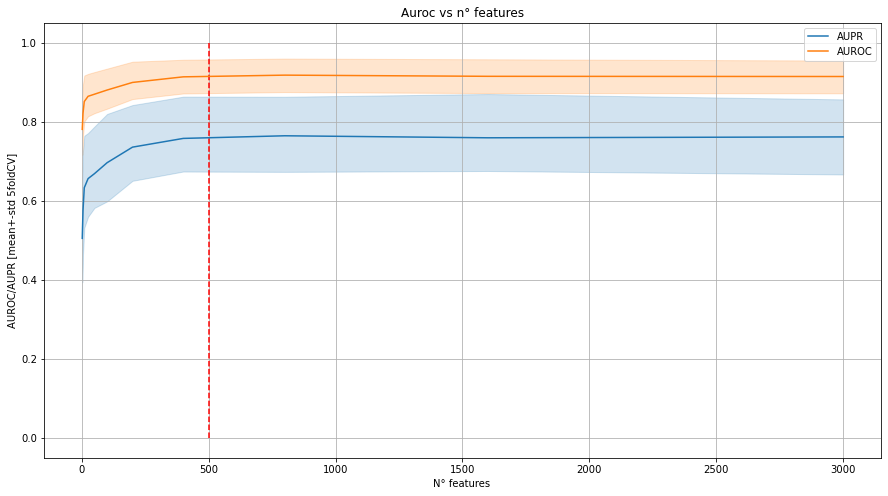

In [46]:
detector = 'hough'
path = (Path.cwd().parent.parent / f'data/haar_models_{detector}/')

aupr_test = pd.read_csv(path/'aupr_test_all_sorted.csv', index_col=0)
cols = aupr_test.columns
aupr_test.reset_index(drop=False, inplace=True)
aupr_test = pd.melt(aupr_test, id_vars=['index'], value_vars=cols)

aucs_test = pd.read_csv(path/'aucs_test_all_sorted.csv', index_col=0)
cols = aucs_test.columns
aucs_test.reset_index(drop=False, inplace=True)
aucs_test =pd.melt(aucs_test, id_vars=['index'], value_vars=cols)

cmap = plt.get_cmap("tab10")
fig, ax = plt.subplots(1,1, figsize=(15,8))
ax.set_title('Auroc vs n° features')
sns.lineplot(x = aupr_test.variable.values.astype(int), y = aupr_test.value, ax=ax, color=cmap(0), label='AUPR')
sns.lineplot(x = aucs_test.variable.values.astype(int), y = aucs_test.value, ax=ax, color=cmap(1), label='AUROC')
ax.set_xlabel('N° features ')
ax.set_ylabel('AUROC/AUPR [mean+-std 5foldCV]')
plt.vlines(x=500, ymin=0, ymax=1, ls='--', color='r')
plt.legend()
plt.grid('on')

In [60]:
#intersection between two feature sets

with open('/home/acortinau/projects/calc-det/data/final_haar_500_feat_selection_gsm.p', 'rb') as f:
    selection_gsm = pickle.load(f)
with open('/home/acortinau/projects/calc-det/data/final_haar_500_feat_selection_hough.p', 'rb') as f:
    selection_hough = pickle.load(f)
    
feat_gsm = list(selection_gsm['skimage_haar_feature_types_sel']) +  list(str(selection_gsm['hor_feats_selection'])) + list(str(selection_gsm['rot_feats_selection']))
feat_hough = list(selection_hough['skimage_haar_feature_types_sel']) +  list(str(selection_hough['hor_feats_selection'])) + list(str(selection_hough['rot_feats_selection']))

selection_gsm_set = set(feat_gsm)
intersection = selection_gsm_set.intersection(feat_hough)
len(intersection)

38